# MNS - Biological Plausible Deep Learning
## Simple Backprop Baselines (DNNs and CNNs)

#### 1. Data Setup - Loading and Viz
#### 2. PyTorch DNNs with Bayesian Optimization
#### 3. PyTorch CNNs with Bayesian Optimization

#### TODO: 4. Plot Learning Dynamics - Weight Changes
#### TODO: 5. Plot BO Volatility

In [ ]:
!pip install -r requirements.txt --quiet

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Import Packages
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

# Import tf for tensorboard monitoring of training
import tensorflow as tf

# Import Network Architectures
from DNN import DNN, eval_dnn
from CNN import CNN, eval_cnn

# Import log-helper/learning plot functions
from helpers import *
from plotting import *
from logger import *

# Import Bayesian Optimization Module
from bayesian_opt import BO_NN

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print("Torch Device: {}".format(torch.cuda.get_device_name(0)))
else:
    print("Torch Device: Local CPU")

Torch Device: Local CPU


In [4]:
# Create all necessary directory if non-existent
data_dir = os.getcwd() +"/data"
global data_dir

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print("Created New Data Directory")

fig_dir = os.getcwd() +"/figures"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print("Created New Figures Directory")

# Create Log Directory or remove tensorboard log files in log dir
log_dir = os.getcwd() + "/logs"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    print("Created New Log Directory")
else:
    filelist = [ f for f in os.listdir(log_dir) if f.startswith("events")]
    for f in filelist:
        os.remove(os.path.join(log_dir, f))
    print("Deleted Old TF/TensorBoard Log Files in Existing Log Directory")
    
models_dir = os.getcwd() + "/models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print("Created New Model Directory")

Deleted Old TF/TensorBoard Log Files in Existing Log Directory


# Download, Import and Plot Datasets

In [5]:
download_data()

No download of MNIST needed.
No download of Fashion-MNIST needed.
No download of CIFAR-10 needed.


In [6]:
# MNIST dataset
X_mnist, y_mnist = get_data(num_samples=70000, dataset="mnist")
# MNIST dataset
X_fashion, y_fashion = get_data(num_samples=70000, dataset="fashion")
# MNIST dataset
X_cifar10, y_cifar10 = get_data(num_samples=60000, dataset="cifar10")

In [7]:
mnist_labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
fashion_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
cifar10_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

Saved figure to /Users/rtl/Dropbox/PHD_ECN/COURSES/WiSe_2018_Models_of_Neural_Systems/PROJECT/CODE/figures/mnist.png


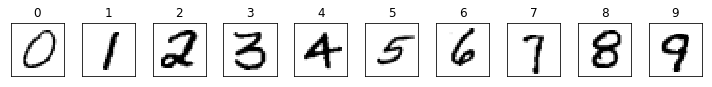

In [8]:
plot_labels(X_mnist, y_mnist, mnist_labels,
            save_fname=fig_dir + "/mnist.png")

Saved figure to /Users/rtl/Dropbox/PHD_ECN/COURSES/WiSe_2018_Models_of_Neural_Systems/PROJECT/CODE/figures/fashion.png


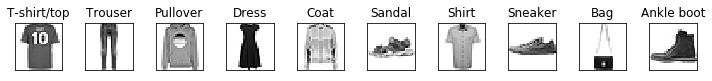

In [9]:
plot_labels(X_fashion, y_fashion, fashion_labels,
            save_fname=fig_dir + "/fashion.png")

Saved figure to /Users/rtl/Dropbox/PHD_ECN/COURSES/WiSe_2018_Models_of_Neural_Systems/PROJECT/CODE/figures/cifar10.png


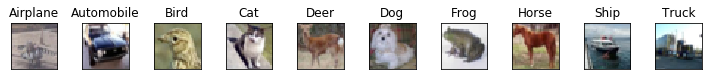

In [10]:
plot_labels(X_cifar10, y_cifar10, cifar10_labels,
            save_fname=fig_dir + "/cifar10.png")

# Simple Feedforward Neural Net

### Run a Simple DNN

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_mnist, y_mnist,
                                                    stratify=y_mnist,
                                                    random_state=0)

# Define batchsize for data-loading/Epochs for training
batch_size = 100
num_epochs = 5
learning_rate = 0.001

# Instantiate the model with layersize and Logging directory
dnn_model = DNN(h_sizes=[784, 500], out_size=10)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=learning_rate)

In [13]:
model = train_model("dnn", dnn_model, num_epochs,
                    X_train, y_train, batch_size,
                    device, optimizer, criterion,
                    log_freq = 20000,
                    model_fname ="models/temp_model_dnn_mnist.ckpt",
                    verbose=True, logging=True)

# Get test error
score = get_test_error("dnn", device, model, X_test, y_test)
print("Test Accuracy: {}".format(score))

train| epoch  1| batch 20000/41996| acc: 0.9738| loss: 0.0992| time: 0.31
valid| epoch  1| batch 20000/41996| acc: 0.9532| loss: 0.2329| time: 0.08
-------------------------------------------------------------------------
train| epoch  1| batch 40000/41996| acc: 0.9605| loss: 0.1577| time: 0.30
valid| epoch  1| batch 40000/41996| acc: 0.9423| loss: 0.2971| time: 0.10
-------------------------------------------------------------------------
train| epoch  2| batch 20000/41996| acc: 0.9735| loss: 0.1118| time: 0.31
valid| epoch  2| batch 20000/41996| acc: 0.9549| loss: 0.2584| time: 0.09
-------------------------------------------------------------------------
train| epoch  2| batch 40000/41996| acc: 0.9748| loss: 0.0999| time: 0.37
valid| epoch  2| batch 40000/41996| acc: 0.9554| loss: 0.2396| time: 0.11
-------------------------------------------------------------------------
train| epoch  3| batch 20000/41996| acc: 0.9745| loss: 0.1028| time: 0.30
valid| epoch  3| batch 20000/41996| ac

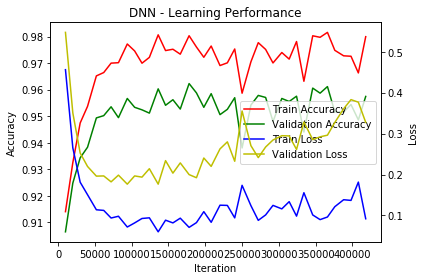

In [15]:
# log_fname = get_latest_log_fname(log_dir)
log_fname = os.getcwd() + "/logs/log_mnist_10_epochs_500_10"
its, train_loss, val_loss, train_acc, val_acc = process_logger_learning(log_fname)
plot_learning(its, train_acc, val_acc, train_loss, val_loss, "DNN - Learning Performance")

### Compute Cross Validation Accuracy for all 3 Datasets

In [ ]:
# Run 3-fold cross-validation on specific architecture for MNIST
eval_dnn("mnist", batch_size, learning_rate,
         num_layers=1, h_l_1=500,
         num_epochs=5, k_fold=3, verbose=True)

In [ ]:
# Run 3-fold cross-validation on specific architecture for Fashion-MNIST
eval_dnn("fashion", batch_size, learning_rate,
         num_layers=1, h_l_1=500,
         num_epochs=5, k_fold=3, verbose=True)

In [ ]:
# Run 3-fold cross-validation on specific architecture for CIFAR-10
eval_dnn("cifar10", batch_size, learning_rate,
         num_layers=1, h_l_1=500,
         num_epochs=5, k_fold=3, verbose=True)

### Run Bayesian Optimization on DNN Hyperparameters

In [ ]:
# Define Search Hyperspace for Bayesian Optimization on DNN architectures
hyper_space_dnn = {'batch_size': (10, 500),
                   'learning_rate': (0.0001, 0.05),
                   'num_layers': (1, 6),
                   'h_l_1': (30, 500),
                   'h_l_2': (30, 500),
                   'h_l_3': (30, 500),
                   'h_l_4': (30, 500),
                   'h_l_5': (30, 500),
                   'h_l_6': (30, 500)}

In [ ]:
# Run Bayesian Optimization (UCB-Acquisition Fct) on DNN for MNIST
opt_log = BO_NN(2, eval_dnn, "dnn", "mnist", hyper_space_dnn,
                num_epochs=10, k_fold=3, logging=True, verbose=True)

In [ ]:
# Run Bayesian Optimization (UCB-Acquisition Fct) on DNN for Fashion-MNIST
opt_log = BO_NN(2, eval_dnn, "dnn", "fashion", hyper_space_dnn,
                num_epochs=10, k_fold=3, logging=True, verbose=True)

In [ ]:
# Run Bayesian Optimization (UCB-Acquisition Fct) on DNN for CIFAR-10
opt_log = BO_NN(2, eval_dnn, "dnn", "cifar10", hyper_space_dnn,
                num_epochs=10, k_fold=3, logging=True, verbose=True)

# Simple Convolutional Neural Network

In [ ]:
# ConvNet Parameters
batch_size = 100
ch_sizes = [1, 16, 32]
k_sizes = [5, 5]
stride = 1
padding = 2
out_size = 10
num_epochs = 2
learning_rate = 0.001

# Instantiate the model with layersizes, Loss fct, optimizer
cnn_model = CNN(ch_sizes, k_sizes,
                stride, padding, out_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [ ]:
model = train_model("cnn", cnn_model, num_epochs,
                    X_train, y_train, batch_size,
                    device, optimizer, criterion, log_freq=10000,
                    model_fname ="models/temp_model_cnn.ckpt",
                    verbose=False, logging=True)

# Get test error
score = get_test_error("cnn", device, model, X_test, y_test)
print("Test Accuracy: {}".format(score))

In [ ]:
log_fname = get_latest_log_fname(log_dir)
its, train_loss, val_loss, train_acc, val_acc = process_logger(log_fname)
plot_learning(its, train_acc, val_acc, train_loss, val_loss, "CNN - Learning Performance")

In [ ]:
# Run 3-fold cross-validation on specific architecture
eval_cnn(batch_size, learning_rate, num_layers=2,
         ch_1=16, ch_2=32, k_1=5, k_2=5,
         stride=1, padding=2,
         k_fold=2, verbose=True)

In [ ]:
# Run Bayesian Optimization (UCB-Acquisition Fct) on DNN
hyper_space_cnn = {'batch_size': (10, 500),
                   'learning_rate': (0.0001, 0.05),
                   'num_layers': (1, 5),
                   'ch_1': (3, 64),
                   'ch_2': (3, 64),
                   'ch_3': (3, 64),
                   'ch_4': (3, 64),
                   'ch_5': (3, 64),
                   'k_1': (2, 10),
                   'k_2': (2, 10),
                   'k_3': (2, 10),
                   'k_4': (2, 10),
                   'k_5': (2, 10),
                   'stride': (1, 3),
                   'padding': (1, 3)}

opt_log = BO_NN(3, eval_cnn, "cnn", hyper_space_cnn, logging=False, verbose=True)

### Visualization of Weight Changes/Learning Dynamics

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_mnist, y_mnist,
                                                    stratify=y_mnist,
                                                    random_state=0)

# Define batchsize for data-loading/Epochs for training
batch_size = 100
num_epochs = 10
learning_rate = 0.001

# Instantiate the model with layersize and Logging directory
dnn_model = DNN(h_sizes=[784, 500], out_size=10)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=learning_rate)

model = train_model("dnn", dnn_model, 10,
                    X_train, y_train, batch_size,
                    device, optimizer, criterion,
                    log_freq = 5000,
                    model_fname ="models/temp_model_dnn_mnist.ckpt",
                    verbose=False, logging=True)

In [17]:
wlog_fname = os.getcwd() + "/logs/weight_log_mnist_10_epochs_500_10.pkl"
iterations, fr_n_weights_ch, fr_n_weight_grad_ch, fr_n_biases_ch, fr_n_bias_grad_ch = process_logger_weights(wlog_fname)

In [54]:
def plot_weight_dev(iterations, fr_n_weights_ch, fr_n_weight_grad_ch,
                    fr_n_biases_ch, fr_n_bias_grad_ch):
    
    fig, ax = plt.subplots(2, 2, figsize=(18, 16), dpi=200)
    fig.suptitle('Learning Dynamics and Convergence of Optimization'.format(type), fontsize=12)
    #fig.tight_layout(rect=[0, 0, 1.2, 0.975])

    ax[0, 0].plot(iterations, fr_n_weights_ch, label="DNN - Backprop")
    ax[0, 0].set_ylabel(r"$\frac{||W_{t+1} - W_{t}||_F}{||W_{t}||_F}$", fontsize=15)
    ax[0, 0].legend()
    
    ax[0, 1].plot(iterations, fr_n_biases_ch, label="DNN - Backprop")
    ax[0, 1].set_ylabel(r"$\frac{||b_{t+1} - b_{t}||_F}{||b_{t}||_F}$", fontsize=15)
    ax[0, 1].legend()
    
    ax[1, 0].plot(iterations, fr_n_weight_grad_ch, label="DNN - Backprop")
    ax[1, 0].set_xlabel("Iteration", fontsize=15)
    ax[1, 0].set_ylabel(r"$\frac{||\nabla W_{t+1} - \nabla W_{t}||_F}{||\nabla W_{t}||_F}$", fontsize=15)
    ax[1, 0].legend()
    
    ax[1, 1].plot(iterations, fr_n_bias_grad_ch, label="DNN - Backprop")
    ax[1, 1].set_xlabel("Iteration", fontsize=15)
    ax[1, 1].set_ylabel(r"$\frac{||\nabla b_{t+1} - \nabla b_{t}||_F}{||\nabla b_{t}||_F}$", fontsize=15)
    ax[1, 1].legend()

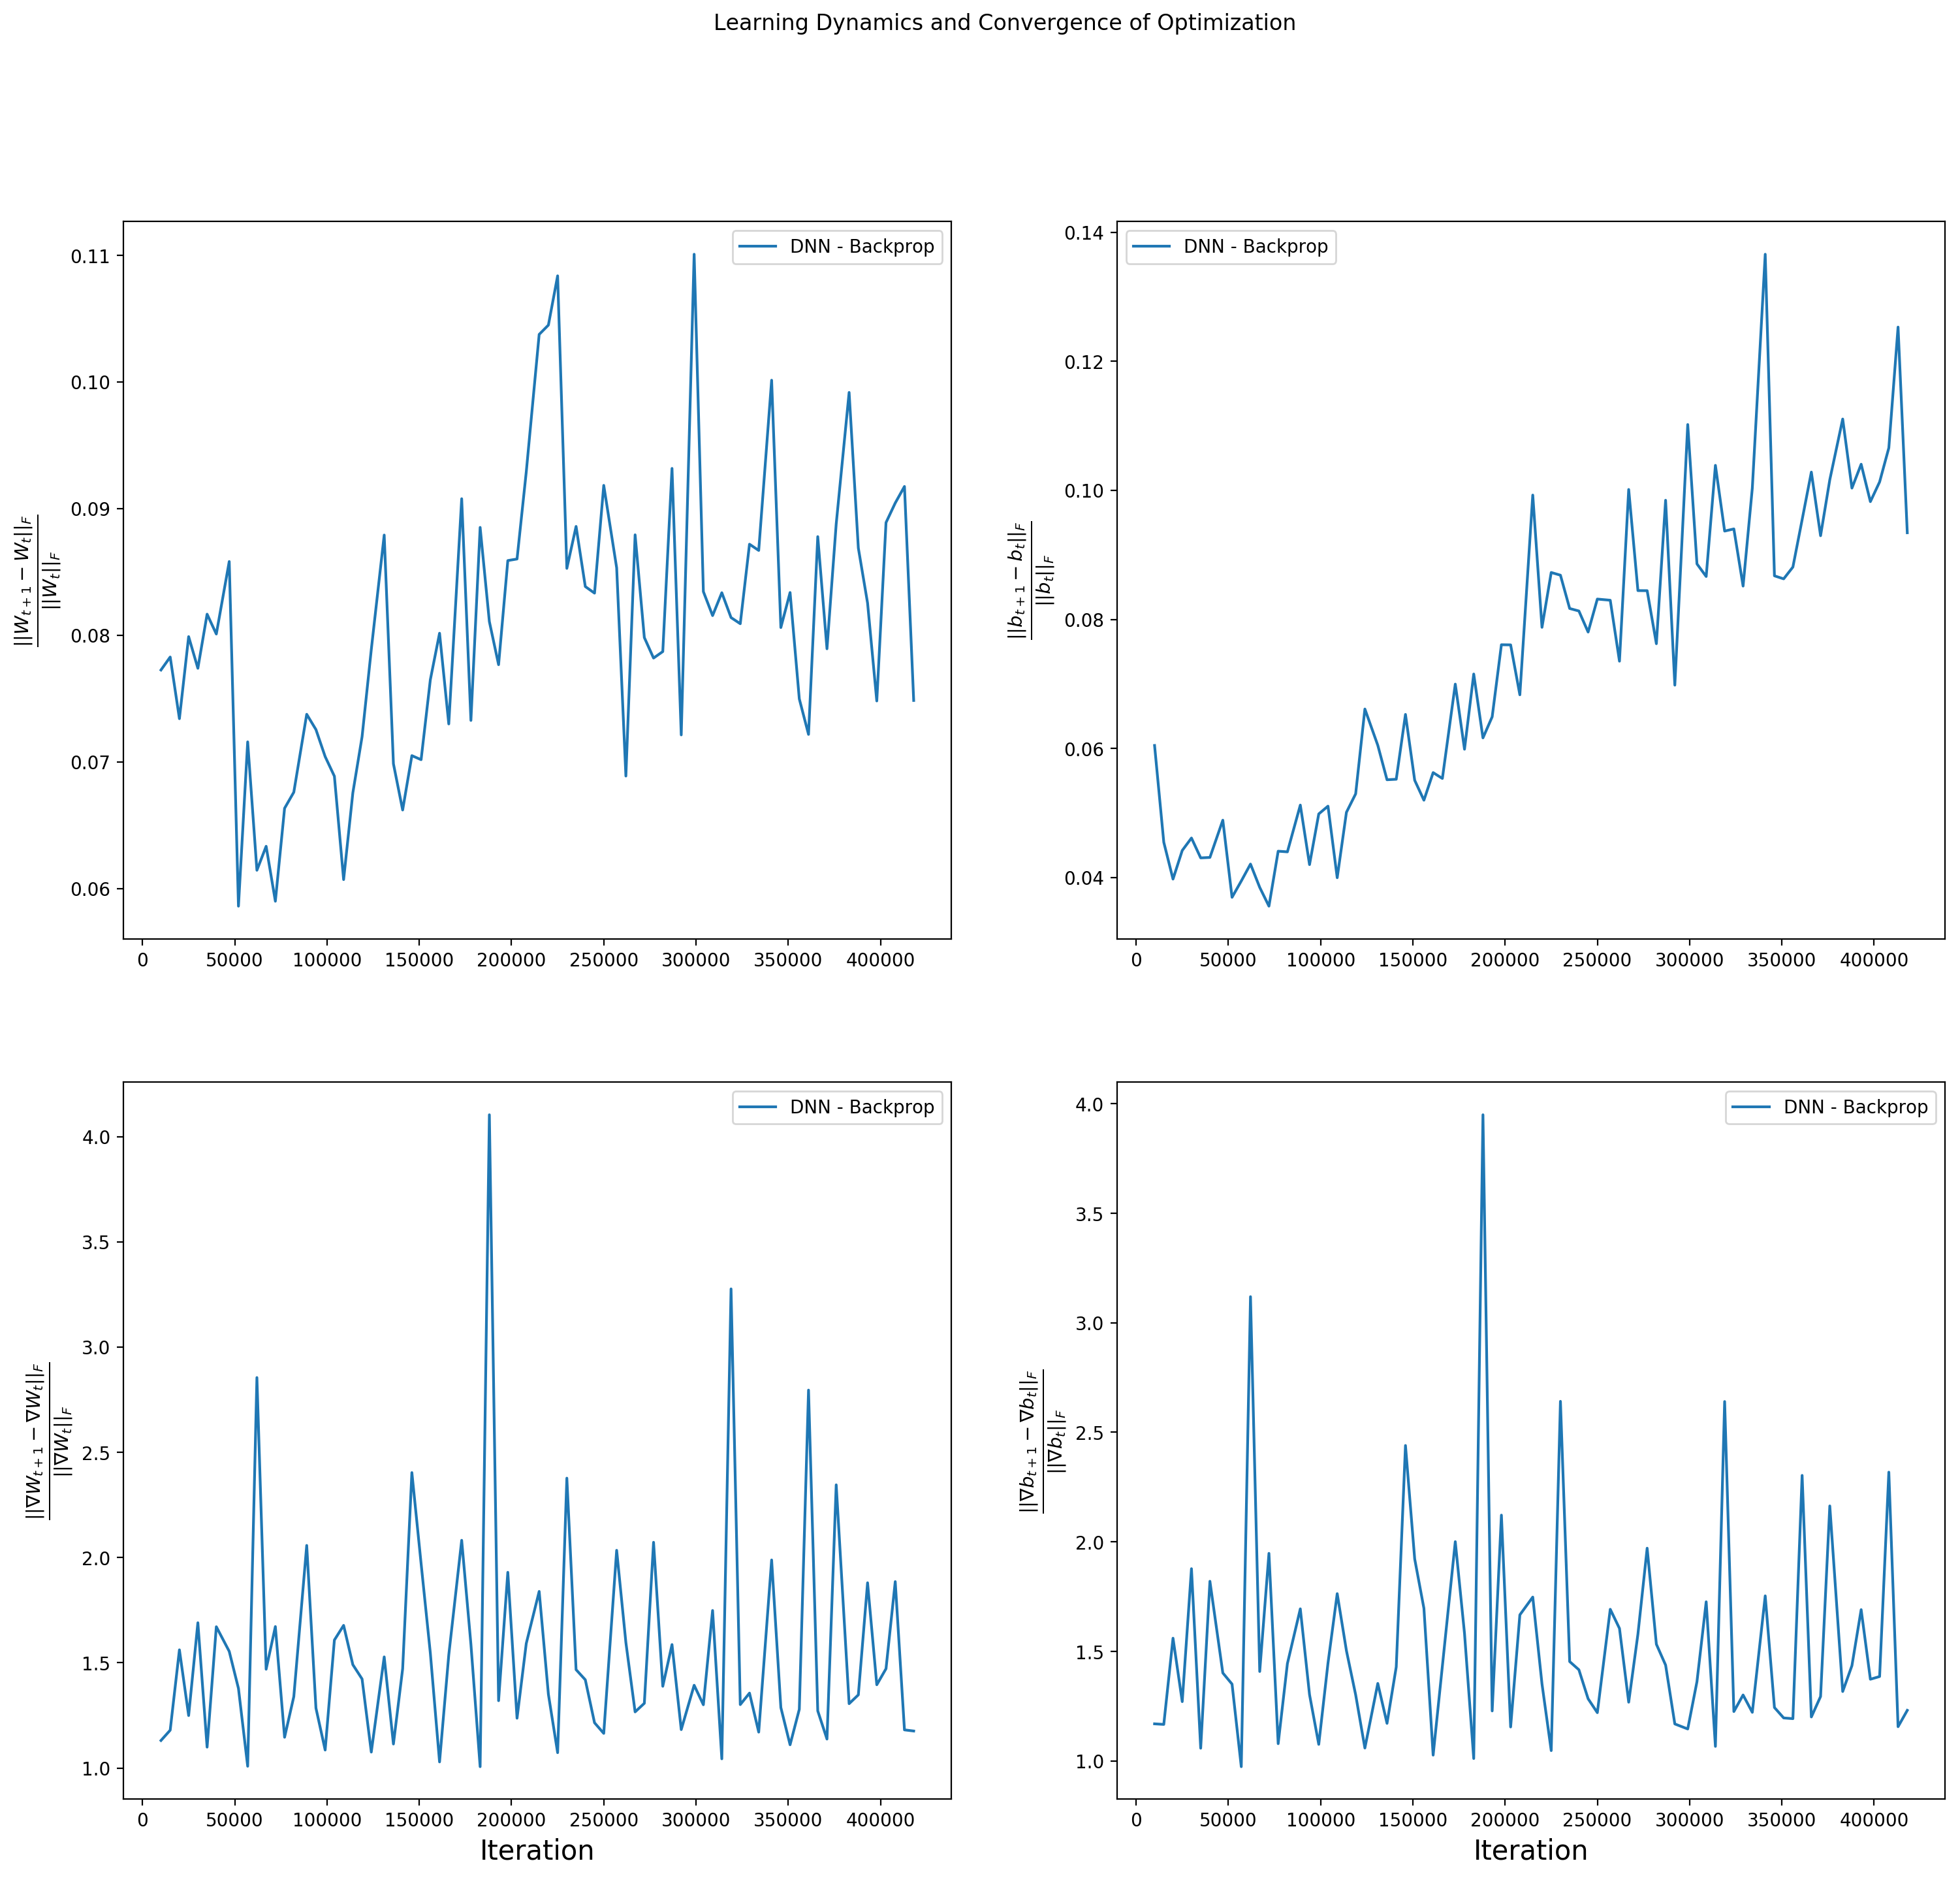

In [55]:
plot_weight_dev(iterations, fr_n_weights_ch[0], fr_n_weight_grad_ch[0],
                fr_n_biases_ch[0], fr_n_bias_grad_ch[0])